In [1]:
import os
import pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
# resolve paths
PROJECT_ROOT = Path(os.getcwd()).parent
output_dir = PROJECT_ROOT / 'outputs'
output_dir.mkdir(exist_ok=True, parents=True)
asset_dir = PROJECT_ROOT / 'assets'
asset_dir.mkdir(exist_ok=True, parents=True)

In [3]:
# convert logs to dataframe
key2rows = {
    'SAE Version': [],
    'Lang': [],
    'Quantile': [],
    'Step': [],
    'Loss': [],
    'Sparsity': [],
}
rename = {
    'gated': 'Gated',
    'standard': 'Standard',
    'q2': '50%',
    'q3': '75%',
}
for sae_version in ('standard', 'gated'):
    for lang in ('ko',):  # ('ko', 'en')
        for q in ('q2', 'q3'):
            run_dir = output_dir / f'sae-{sae_version}_exaone-8b_keat-{lang}_{q}'
            logs_path = run_dir / 'logs.pkl'
            with open(logs_path, 'rb') as fpi:
                logs = pickle.load(fpi)
            for step, values in logs.items():
                key2rows['SAE Version'].append(rename[sae_version])
                key2rows['Lang'].append(lang)
                key2rows['Quantile'].append(rename[q])
                key2rows['Step'].append(step)
                key2rows['Loss'].append(values['loss'])
                key2rows['Sparsity'].append(values['sparsity_loss'])
dfs = pd.DataFrame(key2rows)

In [4]:
# group steps
grouping_size = 2000
dfs['Step'] = (dfs['Step'] // grouping_size) * grouping_size
dfs

,SAE Version,Lang,Quantile,Step,Loss,Sparsity
0,Standard,ko,50%,0,53.518250,907.499390
1,Standard,ko,50%,0,13.958097,87.578857
2,Standard,ko,50%,0,8.495938,25.249798
3,Standard,ko,50%,0,7.061389,25.437862
4,Standard,ko,50%,0,6.315487,37.904819
...,...,...,...,...,...,...
2197,Gated,ko,75%,88000,34.449203,12.076888
2198,Gated,ko,75%,88000,29.161541,10.045850
2199,Gated,ko,75%,88000,32.309525,11.214554
2200,Gated,ko,75%,88000,48.158051,15.719995


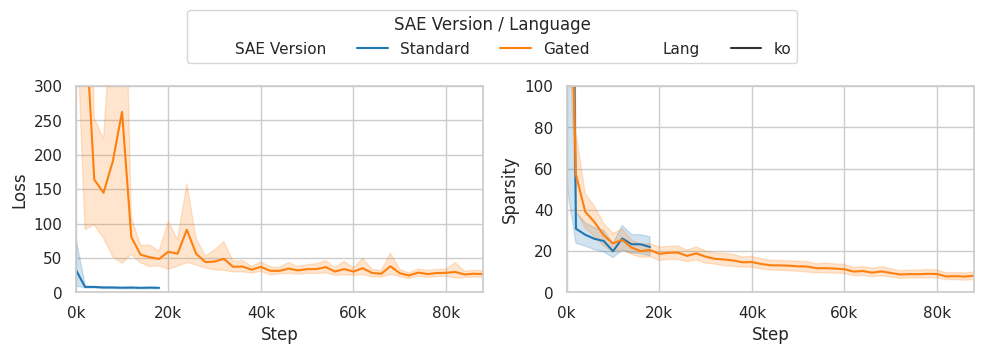

In [5]:
# prepare plot
sns.set_theme(style='whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
xticks = range(0, int(dfs['Step'].max()), 20000)  # x-ticks every 20k steps
palette = (
    '#1f77b4',
    '#ff7f0e',
)

# plot loss
sns.lineplot(
    data=dfs,
    x='Step',
    y='Loss',
    hue='SAE Version',  # per version
    style='Lang',  # per language
    ax=axes[0],
    palette=palette[:2],
)
axes[0].set_xticks(xticks)
axes[0].set_xticklabels([f'{x // 1000}k' for x in xticks])
axes[0].set_xlim(0, dfs['Step'].max() - grouping_size)  # removing the last group
axes[0].set_ylim(0, 300)  # gut feeling
axes[0].get_legend().remove()

# plot sparsity
sns.lineplot(
    data=dfs,
    x='Step',
    y='Sparsity',
    hue='SAE Version',  # per version
    style='Lang',  # per language
    ax=axes[1],
    palette=palette[:2],
)
axes[1].set_xticks(xticks)
axes[1].set_xticklabels([f'{x // 1000}k' for x in xticks])
axes[1].set_xlim(0, dfs['Step'].max() - grouping_size)  # removing the last group
axes[1].set_ylim(0, 100)  # gut feeling
axes[1].get_legend().remove()

# legend setting
handles1, labels1 = axes[0].get_legend_handles_labels()
fig.legend(
    handles1,
    labels1,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.2),
    ncol=6,
    title="SAE Version / Language",
)

# save plot
plt.tight_layout()
plt.savefig(asset_dir / 'loss_sparsity_lang.png', bbox_inches='tight')

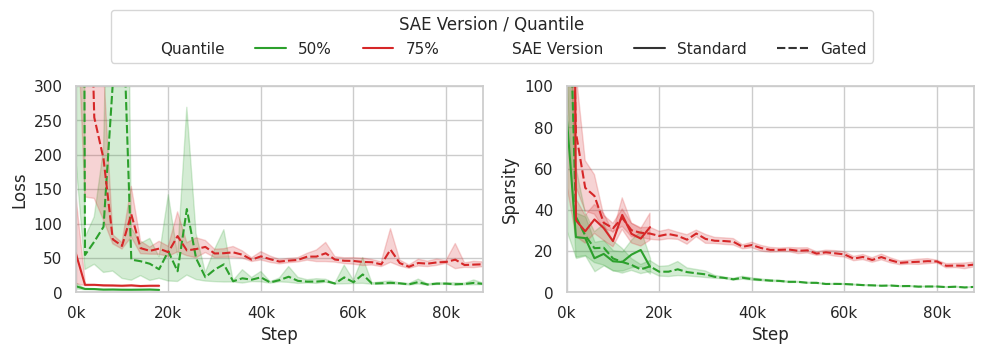

In [6]:
# prepare plot
sns.set_theme(style='whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
xticks = range(0, int(dfs['Step'].max()), 20000)  # x-ticks every 20k steps
palette = (
    "#2ca02c",
    "#d62728",
)

# plot loss
sns.lineplot(
    data=dfs,
    x='Step',
    y='Loss',
    hue='Quantile',  # per quantlie
    style='SAE Version',  # per version
    ax=axes[0],
    palette=palette[:2],
)
axes[0].set_xticks(xticks)
axes[0].set_xticklabels([f'{x // 1000}k' for x in xticks])
axes[0].set_xlim(0, dfs['Step'].max() - grouping_size)  # removing the last group
axes[0].set_ylim(0, 300)  # gut feeling
axes[0].get_legend().remove()

# plot sparsity
sns.lineplot(
    data=dfs,
    x='Step',
    y='Sparsity',
    hue='Quantile',  # per quantlie
    style='SAE Version',  # per version
    ax=axes[1],
    palette=palette[:2],
)
axes[1].set_xticks(xticks)
axes[1].set_xticklabels([f'{x // 1000}k' for x in xticks])
axes[1].set_xlim(0, dfs['Step'].max() - grouping_size)  # removing the last group
axes[1].set_ylim(0, 100)  # gut feeling
axes[1].get_legend().remove()

# legend setting
handles1, labels1 = axes[0].get_legend_handles_labels()
fig.legend(
    handles1,
    labels1,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.2),
    ncol=6,
    title="SAE Version / Quantile",
)

# save plot
plt.tight_layout()
plt.savefig(asset_dir / 'loss_sparsity_quantile.png', bbox_inches='tight')